## Import the necessary software libraries:

In [1]:
import os
import torch
import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch import nn as nn
from torch.optim import AdamW
import torch.nn.functional as F

from utils import test_policy_network, seed_everything, plot_stats
from parallel_env import ParallelEnv, ParallelWrapper

### import ROM from the extracted file to atari_py

In [ ]:
# for gym 0.20+
# from ale_py import ALEInterface

In [ ]:
# for gym 0.20+
# ale = ALEInterface()

In [ ]:
# for gym 0.20+
# ! ale-import-roms /opt/anaconda3/envs/pongA2C/lib/python3.8/site-packages/ale_py/roms/

In [ ]:
# run only once when creating conda environment
! python -m atari_py.import_roms /Users/meng/Downloads/Roms

In [ ]:
# for gym 0.20+
# from ale_py.roms import Pong

In [ ]:
# for gym 0.20+
# ale.loadROM(Pong)

In [ ]:
# no need to run?
import atari_py

In [ ]:
pip install pyglet

In [18]:
env_name = 'CartPole-v1'

env = gym.make(env_name, render=False)

dims = env.observation_space.shape

actions = env.action_space.n

TypeError: __init__() got an unexpected keyword argument 'render'

In [3]:
print(f"State dimensions: {dims}. Actions: {actions}")
print(f"Sample state: {env.reset()}")

State dimensions: (6,). Actions: 3
Sample state: [ 0.9953607   0.09621372  0.99937324  0.03539956 -0.04255242 -0.09800652]


In [16]:
plt.imshow(env.render(mode='rgb_array'))

2023-02-15 16:58:05.533 python[9908:823769] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fde487a22c0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-02-15 16:58:05.534 python[9908:823769] Warning: Expected min height of view: (<NSButton: 0x7fde46add820>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-02-15 16:58:05.537 python[9908:823769] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fde46addad0>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.
2023-02-15 16:58:05.539 python[9908:823769] Warning: Expected min height of view: (<NSPopoverTouchBarItemButton: 0x7fde46ade620>) to be less than or equal to 30 but got a height of 32.000000. This error will be logged once per view in violation.


NameError: name 'glPushMatrix' is not defined

In [4]:
class Environment:

    def __init__(self, env_name):
        self.env = gym.make(env_name)
        seed_everything(self.env)

    def reset(self):
        state = self.env.reset()
        return torch.from_numpy(state).float()

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.env.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.env.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [5]:
class PreprocessEnv(ParallelWrapper):

    def __init__(self, env):
        super().__init__(env)

    def reset(self):
        state = self.venv.reset()
        return torch.from_numpy(state).float()

    def step_async(self, actions):
        actions = actions.squeeze().numpy()
        self.venv.step_async(actions)

    def step_wait(self):
        next_state, reward, done, info = self.venv.step_wait()
        next_state = torch.from_numpy(next_state).float()
        reward = torch.tensor(reward).unsqueeze(1).float()
        done = torch.tensor(done).unsqueeze(1)
        return next_state, reward, done, info

In [6]:
class Actor(torch.distributions.Categorical, nn.Module):

    def __init__(self, input_shape, n_actions):
        #probs = torch.tensor([0.2, 0.3, 0.5])
        torch.distributions.Categorical
        super().__init__()
        

        self.fc1 = nn.Linear(in_features=input_shape[0], out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x
    

In [7]:
class Actor(nn.Module):

    def __init__(self, input_shape, n_actions):
        super().__init__()
        

        self.fc1 = nn.Linear(in_features=input_shape[0], out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=64)
        self.fc3 = nn.Linear(in_features=64, out_features=n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
class Actor(nn.Module):

    def __init__(self, input_shape, n_actions):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=64*8*8, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=n_actions)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        

In [8]:
class Critic(nn.Module):

    def __init__(self, dims):
        super().__init__()

        self.fc1 = nn.Linear(dims, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [9]:
class ActorCritic:
    def __init__(self, actor, critic, alpha=1e-4, gamma=0.99):
        self.actor = actor
        self.critic = critic
        self.alpha = alpha
        self.gamma = gamma
        self.actor_optim = AdamW(self.actor.parameters(), lr=1e-3)
        self.critic_optim = AdamW(self.critic.parameters(), lr=1e-4)
        self.stats = {'Actor Loss': [], 'Critic Loss': [], 'Returns': []}

    def train(self, env, episodes):
        for episode in tqdm(range(1, episodes + 1)):
            state = env.reset()
            done_b = torch.zeros((env.num_envs, 1), dtype=torch.bool)
            ep_return = torch.zeros((env.num_envs, 1))
            I = 1.

            while not done_b.all():
                #action = self.actor(state).multinomial(1).detach()
                probs = self.actor(state)
                action = torch.multinomial(probs, 1).squeeze().detach()
                

                next_state, reward, done, _ = env.step(action)

                value = self.critic(state)
                target = reward + ~done * self.gamma * self.critic(next_state).detach()
                critic_loss = nn.functional.mse_loss(value, target)
                self.critic_optim.zero_grad()
                critic_loss.backward()
                self.critic_optim.step()


                advantage = (target - value).detach()
                #probs = self.actor(state)
                log_probs = torch.log(probs + 1e-6)
                
                action = action.view(-1, 1)
                action_log_prob = log_probs.gather(1, action)
                
                
                action_log_prob = log_probs.gather(1, action)
                entropy = - torch.sum(probs * log_probs, dim=-1, keepdim=True)
                actor_loss = - I * action_log_prob * advantage - 0.01 * entropy
                actor_loss = actor_loss.mean()
                self.actor_optim.zero_grad()
                actor_loss.backward()
                self.actor_optim.step()

                ep_return += reward
                done_b |= done
                state = next_state
                I = I * self.gamma

            self.stats['Actor Loss'].append(actor_loss.item())
            self.stats['Critic Loss'].append(critic_loss.item())
            self.stats['Returns'].append(ep_return.mean().item())

In [ ]:

    #def plot_stats(self):
    #    plt.plot(self.stats['Actor Loss'], label='Actor Loss')
    #    plt.plot(self.stats['Critic Loss'], label='Critic Loss')
    #    plt.plot(self.stats['Returns'], label='Returns')
    #    plt.legend()
    #    plt.show()

    #def test_policy_network(self, env, episodes=2):
    #    with torch.no_grad():
    #        for episode in range(episodes):
    #            state = env.reset()
    #            done = False
    #            total_reward = 0

    #            while not done:
    #                action = self.actor(state).argmax(dim=1).detach()
    #                next_state, reward, done, _ = env.step(action)
    #                total_reward += reward
    #                state = next_state

    #            print(f'Episode {episode+1}: Total reward = {total_reward.item()}')


In [10]:
env_name = 'Acrobot-v1'
num_envs = os.cpu_count()
episodes = 100

#seed_everything(env_name)
#envs = ParallelEnv([Environment(env_name) for _ in range(num_envs)])
#envs = PreprocessEnv(envs)

#plot_stats(agent.stats, smoothed=True)

In [11]:
envs = ParallelEnv([lambda: Environment(env_name).env for _ in range(num_envs)])
envs = PreprocessEnv(envs)

In [12]:
actor = Actor(envs.observation_space.shape, envs.action_space.n)
critic = Critic(envs.observation_space.shape[0])
agent = ActorCritic(actor, critic)
agent.train(envs, episodes)

100%|███████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:42<00:00,  1.03s/it]


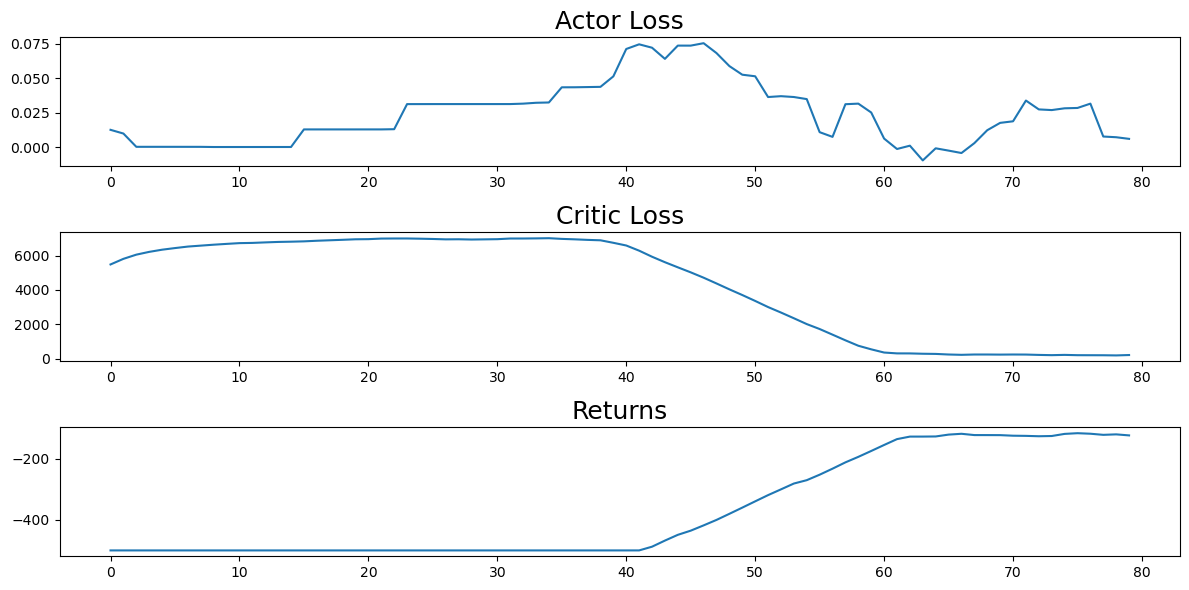

In [13]:
plot_stats(agent.stats)

In [ ]:
test_policy_network(env, agent.actor, episodes=2)